In [1]:
import numpy as np
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.crs import EqualEarth, PlateCarree  
import matplotlib.gridspec as gridspec
import xeofs as xe
import xarray as xr
import h5py

This notebook is in part modeled after this EOF analysis of sea surface temperature data: https://podaac.github.io/tutorials/notebooks/DataStories/eof_example_ersst.html.

#### 1) Open $C^*$ values (in mmol/m$^3$) for all years (1992-2022) and store them as a stacked array. Compute vertically-integrated $\Delta C^*$ over the top $1500$ m.

In [4]:
data_folder = "../raw_Cstar_data/"
years = list(range(1992, 2023))  #31 years: 1992 to 2022
cstar_stack = []

#Load each year's file and append to list
for y in years:
    path = os.path.join(data_folder, f"cstar_interp_{y}.h5")
    with h5py.File(path, 'r') as f:
        cstar = f['Cstar'][:] # Use [:] to load data into memory
    cstar_stack.append(cstar)

cstar_stack = np.transpose(cstar_stack, (3, 0, 1, 2))

# load latitude and depth arrays
with h5py.File(path, 'r') as f:
    lat = f['latitude'][:] 
    lon = f['longitude'][:] 

#Stack
cstar_all = np.stack(cstar_stack, axis=-1)         
print('Shape of stacked array (years, lat, lon, depth): ', cstar_all.shape)

# Load \Delta z (vertical grid spacing)
drf_path = "../processed_data/DRF.data" 
drf = np.fromfile(drf_path, dtype='>f4')[:50]

Shape of stacked array (years, lat, lon, depth):  (31, 180, 360, 50)


In [5]:
# Compute \Delta C^* for each year after 1995 and vertically-integrate over the first 33 grid cells in depth (about 1500 m)
dcstar_all = np.diff(cstar_all, axis=0)
dcstar_all = dcstar_all[3:, :, :, :] # truncate to after 1995
print("Shape of $\Delta C^*$ array (lat, lon, depth, years): ",  dcstar_all.shape)

dc_int_1500m = np.zeros((180, 360, 27))
for indt in range(27):
    dc_int_1500m[:, :, indt] = np.nansum(dcstar_all[indt, :, :, :34] * drf[:34], axis=2)

print("Shape of $\widehat{\Delta C^*}$ array (lat, lon, depth, years): ", dc_int_1500m.shape)

Shape of $\Delta C^*$ array (lat, lon, depth, years):  (27, 180, 360, 50)
Shape of $\widehat{\Delta C^*}$ array (lat, lon, depth, years):  (180, 360, 27)


In [6]:
# Conversion to x-array with dimension names and coordinates
# You can provide a dictionary for the 'coords' argument, mapping dimension names to their corresponding coordinate values
years = np.arange(1996, 2023, 1)
lat = np.arange(-89.5, 90.5, 1)
lon = np.arange(-179.5, 180.5, 1)

dcint_xr = xr.Dataset(
    {
        "cint": (("lat", "lon", "time"), dc_int_1500m),
    },
    coords={"lat": lat, "lon": lon, "time": years},
)

print(dcint_xr)

<xarray.Dataset> Size: 14MB
Dimensions:  (lat: 180, lon: 360, time: 27)
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) int64 216B 1996 1997 1998 1999 2000 ... 2019 2020 2021 2022
Data variables:
    cint     (lat, lon, time) float64 14MB 0.0 0.0 0.0 ... 1.353e+03 -620.8


In [7]:
# Detrend: subtract the long-term linear trend
dcint = dcint_xr['cint'].load() #Load the variable into a DataArry object containing a NumPy array
p = dcint.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(dcint['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
dcint_detrend = (dcint - fit) # xarray is smart enough to subtract along the time dim only.

#### 2) Calculate the EOFs and PC timeseries using xeofs

In [9]:
model = xe.single.EOF(
    n_modes=6, # first 6 modes
    use_coslat=True, # apply weight based on latitudinal differences in grid cell sizes
    standardize=False # don't standardize because want to capture magnitude of the signal
    )
model.fit(dcint_detrend, dim='time')  # apply PCA in time

In [10]:
# EOFs ("components"):
components = model.components()

# PC's ("scores"):
# The package automatically normalizes the returned PC's. We back out the raw PC's as well (following https://github.com/nicrie/xeofs/issues/81):
scores_normed = model.scores()
svals = model.singular_values()
scores = scores_normed * svals

print('Shape of the EOF components (num_modes, lat, lon): ', components.shape)
print('Shape of the PC timeseries scores (num_modes, time): ', scores.shape)

Shape of the EOF components (num_modes, lat, lon):  (6, 180, 360)
Shape of the PC timeseries scores (num_modes, time):  (6, 27)


In [12]:
# Calculate the percentage of variance explained by each mode
expvar = model.explained_variance_ratio()
print("Percentage of variance explained: ", expvar.values)
print("Cumulative percentage of variance explained: ",np.cumsum(expvar.values))

Percentage of variance explained:  [0.15532336 0.1151624  0.08855363 0.07167128 0.05649526 0.04702298]
Cumulative percentage of variance explained:  [0.15532336 0.27048575 0.35903938 0.43071066 0.48720593 0.5342289 ]


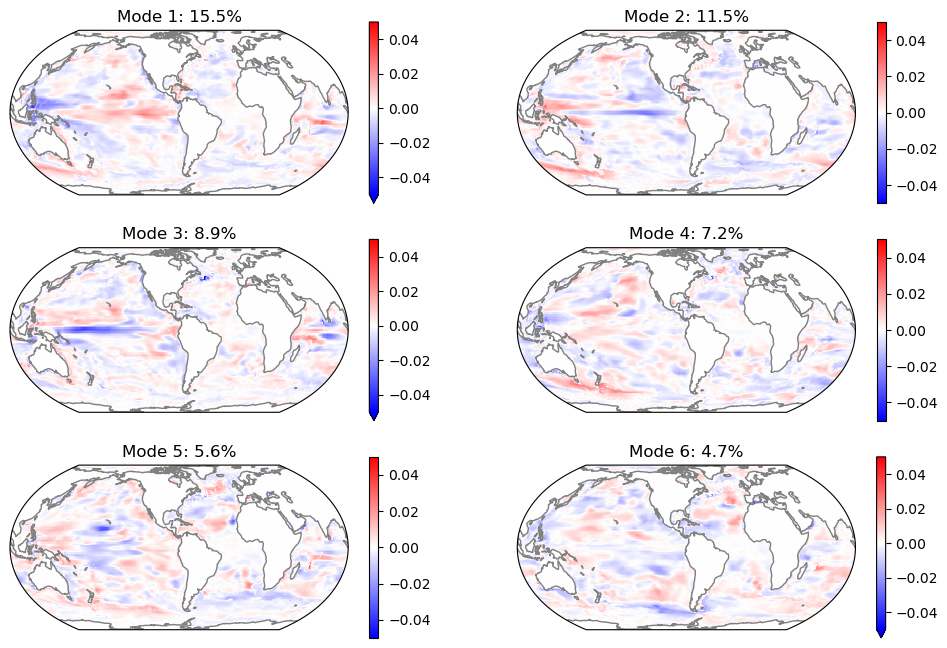

In [13]:
## Plot the top 6 EOFs

fig4 = plt.figure(figsize=(12, 8))
axes4 = []
proj = EqualEarth(central_longitude=-80)
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))


for ax in axes4:
    ax.coastlines(color='.5')


for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(
        ax=ax, vmin=-0.05, vmax=0.05, 
        add_labels=False,
        transform=PlateCarree(), 
        cmap='bwr'
        
        )
    ax.set_title("Mode "+str(i)+": "+str(round(expvar.values[i-1]*100, 1))+"%", fontsize=12)

Save data as HDF5 file

In [15]:
with h5py.File('../processed_data/eof_6modes.h5', 'w') as f:
    dset = f.create_dataset('EOF components', data=components)
    f.create_dataset('PC timeseries', data=scores)
    f.create_dataset('latitude', data=lat)
    f.create_dataset('longitude', data=lon)
    f.create_dataset('years', data=years)

#### 3) Reproduce manuscript figure

In [17]:
# Load pre-processed monthly data for climate indices
clim_index = np.load('../processed_data/climate_indices.npz')
enso = clim_index["enso"] # MEI index for ENSO
emi = clim_index["emi"] # EMI index for El Nino Modoki
atl3 = clim_index["atl3"] # ATL3 index for Atlantic Nino

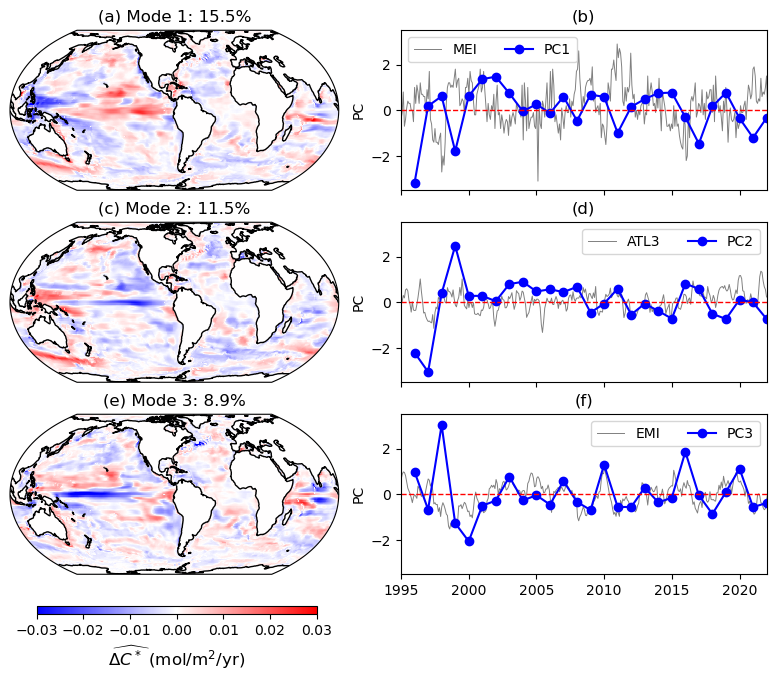

In [18]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[2, 2])
titles = ["(a) ", "(c) ", "(e) "]

proj = EqualEarth(central_longitude=-80)
for i in range(1, 4):
    ax = fig.add_subplot(gs[i-1, 0], projection=proj)
    ax.coastlines()
    im = ax.pcolormesh(lon, lat, components[i-1, :, :], 
         cmap='bwr', vmin=-0.03, vmax=0.03, transform=ccrs.PlateCarree())
    ax.set_title( titles[i-1]+ "Mode "+str(i)+": "+str(round(expvar.values[i-1]*100, 1))+"%", fontsize=12)

ax = fig.add_subplot(gs[0, 1])
pc1 = (scores[0] - np.mean(scores[0]))/np.std(scores[0])
ax.plot(np.linspace(1995, 2023, len(enso)),enso, 'gray', linewidth=0.7, label='MEI')
ax.plot(years, pc1, '-ob', linewidth=1.5,  label='PC1')
ax.legend(ncol=2)
ax.plot(np.linspace(1995, 2023, len(enso)),np.zeros((len(enso),)), '--r', linewidth=1)
ax.set_xlim([1995, 2022])
ax.set_xticklabels([])
ax.set_ylim([-3.5, 3.5])
ax.set(ylabel='PC', title="(b)")

ax = fig.add_subplot(gs[1, 1])
pc2 = (scores[1] - np.mean(scores[1]))/np.std(scores[1])
ax.plot(np.linspace(1995, 2023, len(atl3)),atl3, 'gray', linewidth=0.7, label='ATL3')
ax.plot(years, pc2, '-ob', linewidth=1.5,  label='PC2')
ax.legend(ncol=2)
ax.plot(np.linspace(1995, 2023, len(atl3)),np.zeros((len(atl3),)), '--r', linewidth=1)
ax.set_xlim([1995, 2022])
ax.set_xticklabels([])
ax.set_ylim([-3.5, 3.5])
ax.set(ylabel='PC', title="(d)")

ax = fig.add_subplot(gs[2, 1])
pc3 = (scores[2] - np.mean(scores[2]))/np.std(scores[2])
ax.plot(np.linspace(1995, 2023, len(emi)),emi, 'gray', linewidth=0.7, label='EMI')
ax.plot(years, pc3, '-ob', linewidth=1.5, label='PC3')
ax.legend(ncol=2)
ax.plot(np.linspace(1995, 2023, len(emi)),np.zeros((len(emi),)), '--r', linewidth=1)
ax.set_xlim([1995, 2022])
ax.set_ylim([-3.5, 3.5])
ax.set(ylabel='PC', title="(f)")

fig.subplots_adjust(bottom=0.2, wspace=0.12, hspace=0.2)
cbar_ax = fig.add_axes([0.17, 0.15, 0.28, 0.01])
cb = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", pad=0.2)
cb.set_label(r'$\widehat{\Delta C^*}$ (mol/m$^2$/yr)', fontsize=12)

fig.savefig("../figures/eof_analysis.png", dpi=600, bbox_inches='tight')